# 1) Import and install dependencies

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as pltg
import time
import mediapipe as mp


# 2) Keypoints using MP Hands

In [2]:
mp_hands = mp.solutions.hands # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    image = cv2.flip(image, 1)
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    if not results.multi_hand_landmarks:
        return
    
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            hand_landmarks, 
            mp_hands.HAND_CONNECTIONS
        )


# 3) Extract Keypoints

In [5]:
def extract_keypoints_normalized(results):
    """
    Extract keypoints and normalize them for position and scale invariance.
    Returns a 1D numpy array of length 21*4 per hand (x, y, z, visibility).
    """
    if results.multi_hand_landmarks:
        hands = []
        for hand_landmarks in results.multi_hand_landmarks:
            # Extract raw keypoints
            kp = np.array([[res.x, res.y, res.z, res.visibility] for res in hand_landmarks.landmark])
            
            # Use wrist (landmark 0) as origin
            origin = kp[0, :3]  # x, y, z
            kp[:, :3] -= origin  # subtract wrist position
            
            # Optional: scale normalization (divide by max distance)
            max_dist = np.max(np.linalg.norm(kp[:, :3], axis=1))
            if max_dist > 0:
                kp[:, :3] /= max_dist
            
            hands.append(kp.flatten())
        
        return np.concatenate(hands)
    else:
        # Return zeros if no hand detected
        return np.zeros(21*4)


# 4) Setup Folders for Collection

In [6]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['none', 'nonezoom', 'swipeleft', 'zoom', 'pointyclick', 'middleclick', 'ringclick', 'pinkyclick'])

# Thirty videos worth of data
no_sequences = 40

# Videos are going to be 30 frames in length
sequence_length = 16

### For normal action

In [10]:
new_start = 40; 
new_end = 80;
actions_folder = ['pointyclick'];
for action in actions_folder: 
    for sequence in range(new_start, new_end):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5) Collect Keypoint Values for Training and Testing

In [14]:
# Folder start
start_folder = 'pointyclick'
new_start = 40
new_end = 51

In [ ]:
cap = cv2.VideoCapture(0)
prev_time = 0

action = start_folder

with mp_hands.Hands(min_detection_confidence=0.5, 
                    min_tracking_confidence=0.2, 
                    max_num_hands=1) as hands: 

    # loop through sequences 
    for sequence in range(new_start, new_end): 
        # loop through video length
        for frame_num in range(sequence_length): 
            
            ret, frame = cap.read()
            if not ret:
                break
            
            # make detection 
            image, results = mediapipe_detection(frame, hands)
            
            # Draw landmarks
            draw_landmarks(image, results)
            
            # Calculate FPS
            curr_time = time.time()
            fps = 1 / (curr_time - prev_time) if prev_time != 0 else 0
            prev_time = curr_time
            
            # Put FPS text on image
            cv2.putText(image, f'FPS: {int(fps)}', (10, 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Apply collection logic
            if frame_num == 0: 
                cv2.putText(image, "Starting Collection", (120, 200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, f"Collecting frames for {action} video number {sequence}", (15, 80), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)  # wait 2 seconds at first frame
            else: 
                cv2.putText(image, f"Collecting frames for {action} video number {sequence}", (15, 80), 
                            cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 4, cv2.LINE_AA)
            
            # Export Keypoints
            keypoints = extract_keypoints_normalized(results)
            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
            np.save(npy_path, keypoints) 
            
            # Show to screen
            cv2.imshow('OpenCV Feed', image)
            
            # Exit if 'q' pressed
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

cap.release()
cv2.destroyAllWindows()


In [39]:
keypoints.shape

(84,)

# 6) Preprocess Data and Create labels and features

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [15]:
label_map = {label:num for num, label in enumerate(actions)}

In [16]:
label_map

{'none': 0,
 'nonezoom': 1,
 'swipeleft': 2,
 'zoom': 3,
 'pointyclick': 4,
 'middleclick': 5,
 'ringclick': 6,
 'pinkyclick': 7}

In [17]:
res = np.load(os.path.join(DATA_PATH, actions[0], "0", "0.npy"))
print(res.shape)

(84,)


In [11]:
#old
sequences, labels = [], []

for action in actions:
    # Use more sequences for 'none'
    if action == "none" or action == "nonezoom": 
        num_seq = 160
    elif action == "pointyclick":
        num_seq = 80
    else:
        num_seq = no_sequences
       
    for sequence in range(num_seq):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


In [18]:
import os
import numpy as np

# ==== Rebuild sequences exactly like your old loader ====
sequences, labels = [], []

for action in actions:
    if action in ("none", "nonezoom"):
        num_seq = 160
    elif action == "pointyclick":
        num_seq = 80
    else:
        num_seq = no_sequences
       
    for sequence in range(num_seq):
        window = []
        for frame_num in range(sequence_length):  # expected 16
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy"))
            window.append(res)                     # each res is shape (84,)
        sequences.append(np.array(window))         # shape: (16, 84)
        labels.append(label_map[action])

# ==== Helper to print one frame from a chosen sequence ====
def print_sample_frame(seq_idx, frame_idx=8, num_landmarks=21, coords_per_landmark=4):
    """
    Prints the selected frame from sequences[seq_idx].
    Reshapes (84,) → (21, 4) as [x, y, z, visibility].
    """
    seq = sequences[seq_idx]  # (16, 84)
    assert seq.shape[0] == 16, f"Expected 16 frames, got {seq.shape[0]}"
    frame = seq[frame_idx]    # (84,)
    print(f"Sequence index: {seq_idx}, Label: {labels[seq_idx]}")
    print(f"Sequence shape: {seq.shape}, Frame index: {frame_idx}, Frame shape: {frame.shape}")
    if frame.size == num_landmarks * coords_per_landmark:
        print(frame.reshape(num_landmarks, coords_per_landmark))
    else:
        print(frame)



In [19]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Mediapipe hand landmark connections
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),          # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),          # Index
    (5, 9), (9, 10), (10, 11), (11, 12),     # Middle
    (9, 13), (13, 14), (14, 15), (15, 16),   # Ring
    (13, 17), (17, 18), (18, 19), (19, 20),  # Pinky
    (0, 17)                                  # Palm base connection
]

def plot_frame_landmarks(frame_flat, num_landmarks=21, coords_per_landmark=4, ax=None, title="Frame"):
    """Plots (x, y) coordinates and connects them like a hand skeleton."""
    points = frame_flat.reshape(num_landmarks, coords_per_landmark)
    x, y = points[:, 0], points[:, 1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Draw hand bonds (connections)
    for (start, end) in HAND_CONNECTIONS:
        ax.plot([x[start], x[end]], [y[start], y[end]], c='gray', linewidth=1.5)

    # Draw the landmarks
    ax.scatter(x, y, c='blue', s=40)
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), fontsize=8, color='black', ha='center', va='center')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.axis("equal")
    ax.grid(True)
    return ax


def plot_one_sample_per_label(sequences, labels, label_map, frame_idx=8, num_landmarks=21, coords_per_landmark=4):
    """
    Plots one sample (frame_idx) for each label.
    Each label gets its own subplot with connected landmarks (hand skeleton).
    """
    # Reverse label_map: {0:'swipe_left', 1:'none', ...}
    inv_label_map = {v: k for k, v in label_map.items()}

    unique_labels = sorted(set(labels))
    num_labels = len(unique_labels)
    cols = 4
    rows = math.ceil(num_labels / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        idx = labels.index(label)
        frame_flat = sequences[idx][frame_idx]
        ax = axes[i]
        plot_frame_landmarks(frame_flat, num_landmarks, coords_per_landmark,
                             ax=ax, title=f"{inv_label_map[label]} (label={label})")

    # Hide unused subplots
    for j in range(num_labels, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


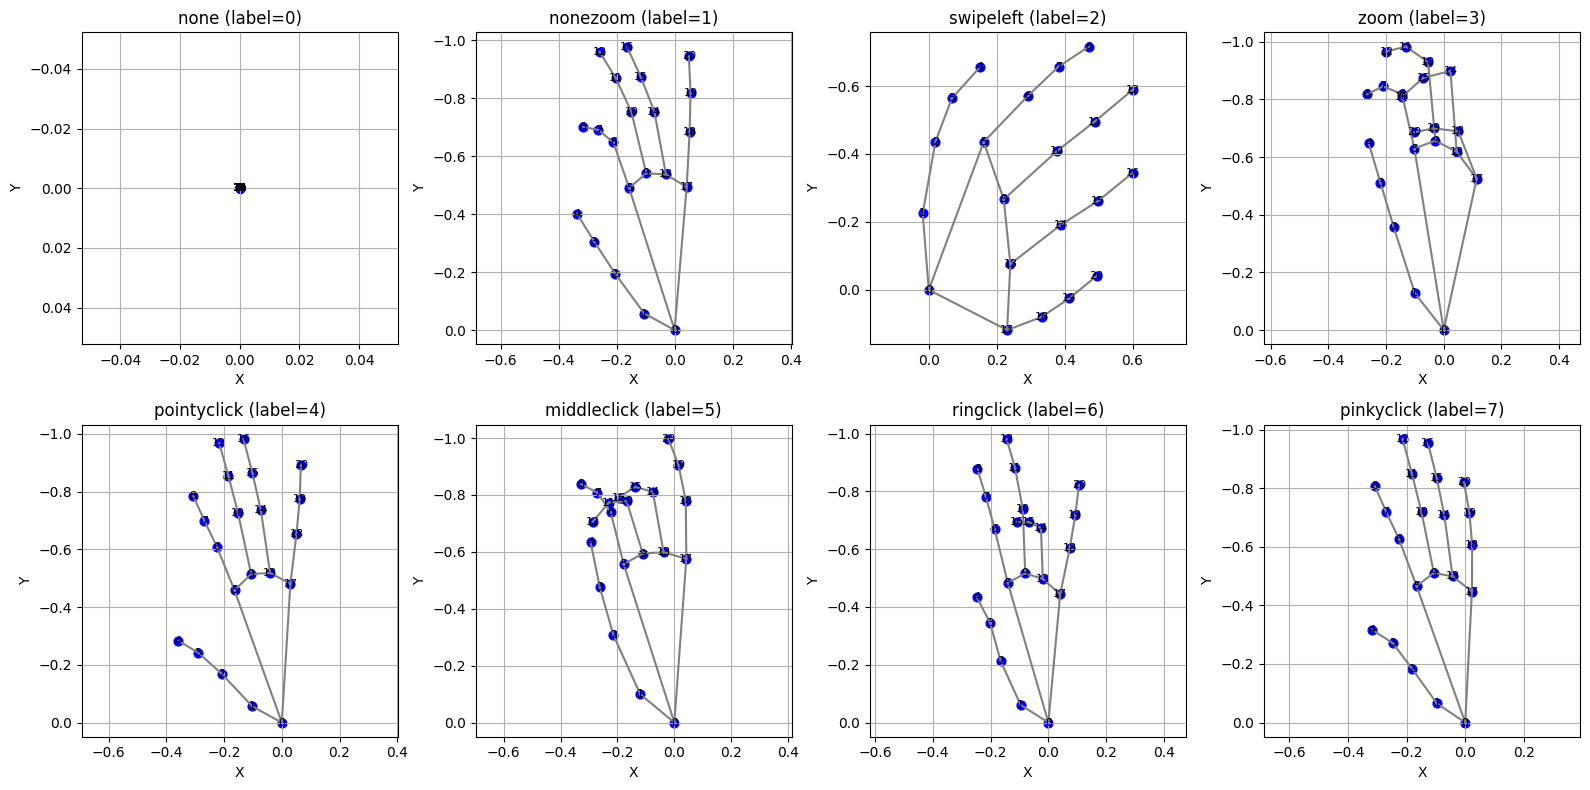

In [20]:
plot_one_sample_per_label(sequences, labels, label_map, frame_idx=8)


In [30]:
import numpy as np
import math
import random

def rotate_flat_points(points_flat, angle_degrees):
    """
    Rotate flattened (N*4,) landmark array around the Z-axis.
    Only rotates X and Y, keeps Z and visibility unchanged.
    """
    angle_radians = math.radians(angle_degrees)
    cos_a, sin_a = math.cos(angle_radians), math.sin(angle_radians)

    points = points_flat.reshape(-1, 4)
    rotated = np.copy(points)

    x, y = points[:, 0], points[:, 1]
    rotated[:, 0] = x * cos_a - y * sin_a
    rotated[:, 1] = x * sin_a + y * cos_a
    return rotated.flatten()


def augment_dataset_with_rotation(sequences, labels, multiplier=5, rotation_range=5):
    """
    Augments the dataset by applying random rotation (-rotation_range, +rotation_range)
    around the Z-axis for each sequence multiple times.

    Args:
        sequences (list[np.ndarray]): Each sequence shape (sequence_length, 84)
        labels (list[int]): Corresponding labels for each sequence
        multiplier (int): Number of augmented copies per sequence
        rotation_range (float): Max rotation angle in degrees (±)

    Returns:
        aug_sequences (list[np.ndarray]), aug_labels (list[int])
    """
    aug_sequences = []
    aug_labels = []
    total = len(sequences)

    for idx, (seq, label) in enumerate(zip(sequences, labels)):
        # Add the original sequence
        aug_sequences.append(seq)
        aug_labels.append(label)

        # Create N rotated copies
        for _ in range(multiplier):
            angle = random.uniform(-rotation_range, rotation_range)
            rotated_seq = np.array([
                rotate_flat_points(frame, angle) for frame in seq
            ])
            aug_sequences.append(rotated_seq)
            aug_labels.append(label)

        # Optional progress display
        if (idx + 1) % 100 == 0 or idx == total - 1:
            print(f"Augmented {idx + 1}/{total} sequences")

    return aug_sequences, aug_labels


In [43]:
aug_sequences, aug_labels = augment_dataset_with_rotation(sequences, labels, multiplier=10, rotation_range=10)

print(f"Original dataset size: {len(sequences)}")
print(f"Augmented dataset size: {len(aug_sequences)}") 


Augmented 100/600 sequences
Augmented 200/600 sequences
Augmented 300/600 sequences
Augmented 400/600 sequences
Augmented 500/600 sequences
Augmented 600/600 sequences
Original dataset size: 600
Augmented dataset size: 6600


In [41]:
import matplotlib.pyplot as plt
import numpy as np
import math
import random

# === Mediapipe-style hand landmark connections ===
HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),          # Thumb
    (0, 5), (5, 6), (6, 7), (7, 8),          # Index
    (5, 9), (9, 10), (10, 11), (11, 12),     # Middle
    (9, 13), (13, 14), (14, 15), (15, 16),   # Ring
    (13, 17), (17, 18), (18, 19), (19, 20),  # Pinky
    (0, 17)                                  # Palm base connection
]

# === Rotation helper ===
def rotate_flat_points(points_flat, angle_degrees):
    """Rotate flattened (N*4,) landmark array around the Z-axis."""
    angle_radians = math.radians(angle_degrees)
    cos_a, sin_a = math.cos(angle_radians), math.sin(angle_radians)

    points = points_flat.reshape(-1, 4)
    rotated = np.copy(points)

    x, y = points[:, 0], points[:, 1]
    rotated[:, 0] = x * cos_a - y * sin_a
    rotated[:, 1] = x * sin_a + y * cos_a
    return rotated.flatten()

# === Single-frame plotter ===
def plot_frame_landmarks(frame_flat, ax=None, title="Frame"):
    """Plots 21 (x, y) points with connecting lines like a hand skeleton."""
    points = frame_flat.reshape(21, 4)
    x, y = points[:, 0], points[:, 1]

    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    # Draw hand bonds
    for (start, end) in HAND_CONNECTIONS:
        ax.plot([x[start], x[end]], [y[start], y[end]], c='gray', linewidth=1.5)

    # Draw points
    ax.scatter(x, y, c='blue', s=40)
    for i, (xi, yi) in enumerate(zip(x, y)):
        ax.text(xi, yi, str(i), fontsize=8, color='black', ha='center', va='center')

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.invert_yaxis()
    ax.axis("equal")
    ax.grid(True)
    return ax

# === Visualization for augmented dataset ===
def visualize_from_augmented(aug_sequences, aug_labels, label_map, label_idx, frame_idx=8, num_new_aug=10):
    """
    For a chosen label (from augmented dataset), generate and plot additional rotated versions.
    Does NOT include the original version.
    Rotation angles are sampled from [-30, -10] and [10, 30].
    """
    inv_label_map = {v: k for k, v in label_map.items()}

    # Find the first sample of this label in the augmented data
    try:
        seq_index = aug_labels.index(label_idx)
    except ValueError:
        print(f"❌ Label index {label_idx} not found in augmented dataset.")
        return

    base_seq = aug_sequences[seq_index]
    base_frame = base_seq[frame_idx]  # choose the middle frame

    # Generate new augmentations with angles from [-30,-10] and [10,30]
    aug_frames = []
    for _ in range(num_new_aug):
        if random.random() < 0.5:
            angle = random.uniform(-30, -10)
        else:
            angle = random.uniform(10, 30)
        rotated_frame = rotate_flat_points(base_frame, angle)
        aug_frames.append((angle, rotated_frame))

    # --- Plotting section ---
    total = len(aug_frames)
    cols = 4
    rows = math.ceil(total / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    axes = axes.flatten()

    for i, (angle, frame) in enumerate(aug_frames):
        plot_frame_landmarks(frame, ax=axes[i], title=f"{inv_label_map[label_idx]} Rot {angle:.1f}°")

    # Hide unused subplots
    for j in range(total, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


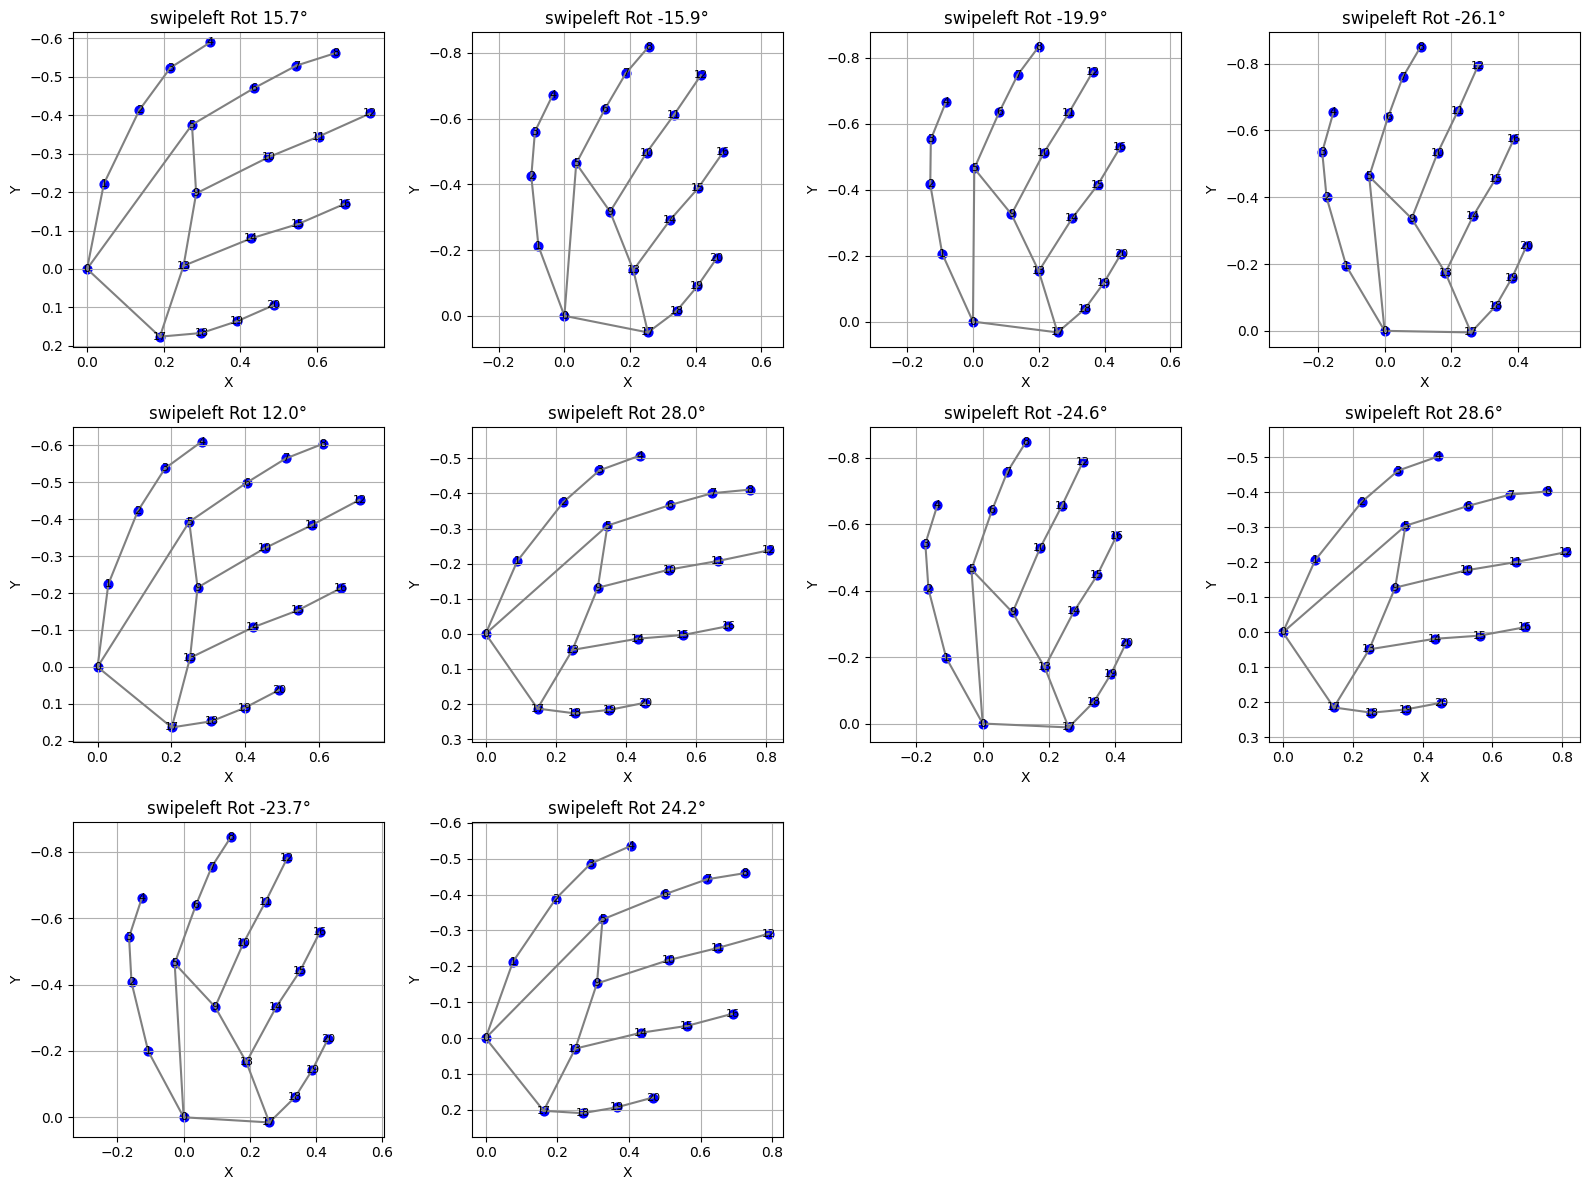

In [42]:
# Suppose you already have aug_sequences, aug_labels, and label_map
visualize_from_augmented(aug_sequences, aug_labels, label_map, label_idx=2)


In [44]:
def merge_datasets(sequences, labels, aug_sequences, aug_labels):
    """
    Merge the original dataset with its augmented version.

    Args:
        sequences (list[np.ndarray]): Original sequences (each shape (16, 84))
        labels (list[int]): Labels for original sequences
        aug_sequences (list[np.ndarray]): Augmented sequences (each shape (16, 84))
        aug_labels (list[int]): Labels for augmented sequences

    Returns:
        merged_sequences (list[np.ndarray]), merged_labels (list[int])
    """
    # Sanity check
    if len(sequences) != len(labels):
        print("⚠️ Warning: original sequences and labels length mismatch.")
    if len(aug_sequences) != len(aug_labels):
        print("⚠️ Warning: augmented sequences and labels length mismatch.")

    merged_sequences = list(sequences) + list(aug_sequences)
    merged_labels = list(labels) + list(aug_labels)

    print(f"✅ Merged dataset successfully:")
    print(f"   Original size: {len(sequences)}")
    print(f"   Augmented size: {len(aug_sequences)}")
    print(f"   Total merged size: {len(merged_sequences)}")

    return merged_sequences, merged_labels


In [45]:
merged_sequences, merged_labels = merge_datasets(sequences, labels, aug_sequences, aug_labels)

print(np.array(merged_sequences).shape)  # should be ((orig + aug), 16, 84)
print(len(merged_labels))


✅ Merged dataset successfully:
   Original size: 600
   Augmented size: 6600
   Total merged size: 7200
(7200, 16, 84)
7200


In [46]:
X = np.array(merged_sequences)

In [47]:
X.shape

(7200, 16, 84)

In [48]:
y = to_categorical(merged_labels).astype(int)

In [49]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

# 7) Build and Train LSTM Neural Network

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [64]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [65]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, GRU, Dense,
    Dropout, BatchNormalization, Attention, Flatten
)
from tensorflow.keras.optimizers import Adam

def build_final_gesture_model(num_classes, input_shape=(16, 84)):
    """
    Final efficient model for dynamic hand gesture recognition.
    Combines Conv1D + GRU + Attention + BatchNorm + Dropout.
    """
    inputs = Input(shape=input_shape)

    # --- Spatial feature extraction ---
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # --- Temporal feature learning (GRUs) ---
    x = GRU(128, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = GRU(64, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # --- Attention mechanism ---
    attention_out = Attention()([x, x])
    x = Flatten()(attention_out)  # flatten attention output

    # --- Fully connected classifier ---
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # --- Compile ---
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [66]:
num_classes = len(actions)
model = build_final_gesture_model(num_classes=num_classes, input_shape=(16, 84))
model.summary()


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 16, 84)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 16, 64)    │     16,192 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 8, 64)     │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_4 (GRU)         │ (None, 8, 128)    │     74,496 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 128)    │        512 │ gru_4[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 8, 128)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 8, 64)     │     37,248 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 64)     │        256 │ gru_5[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 8, 64)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 8, 64)     │          0 │ dropout_7[0][0],  │
│ (Attention)         │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     65,664 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 8)         │        520 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,912 (796.53 KB)

 Trainable params: 203,144 (793.53 KB)

 Non-trainable params: 768 (3.00 KB)

In [67]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3157 - loss: 2.1059
Epoch 2/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7945 - loss: 0.6690
Epoch 3/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9099 - loss: 0.3531
Epoch 4/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9458 - loss: 0.2177
Epoch 5/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9661 - loss: 0.1517
Epoch 6/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9773 - loss: 0.1036
Epoch 7/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9891 - loss: 0.0631
Epoch 8/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9892 - loss: 0.0605
Epoch 9/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9906 - loss: 0.0466
Epoch 10/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9931 - loss: 0.0387
Epoch 11/1000
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9921 - loss: 0.0396
Epoch 12/1000
207/207

KeyboardInterrupt: 

# 8) Make Predictions

In [68]:
res = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [69]:
actions[np.argmax(res[0])]

'none'

In [70]:
actions[np.argmax(y_test[0])]

'none'

# 9) Save Weights

In [71]:
model.save('right_action.h5')

In [141]:
del model

In [145]:
model.load_weights('action.h5')

# 10) Evaluation using confusion matrix and accuracy

In [109]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [110]:
yhat = model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [111]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [112]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[439,   0],
        [  0, 137]],

       [[403,   0],
        [  0, 173]],

       [[533,   0],
        [  0,  43]],

       [[522,   0],
        [  0,  54]],

       [[506,   0],
        [  0,  70]],

       [[548,   0],
        [  0,  28]],

       [[540,   0],
        [  0,  36]],

       [[541,   0],
        [  0,  35]]])

# 11) Test in real time

In [38]:
from scipy import stats

In [44]:
colors = [(245,117,16), (117,245,16), (16,117,245), (245,117,16), (117,245,16), (16,117,245), (245,117,16), (245,117,16), (245,117,16),(245,117,16)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [45]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'plt' is not defined

In [46]:
#new detection variable
sequence = []
sentence = []
threshold = 0.4
predictions = []

# Open webcam
cap = cv2.VideoCapture(0)

# For FPS calculation
prev_time = 0

with mp_hands.Hands(min_detection_confidence=0.5, 
                    min_tracking_confidence=0.2, 
                    max_num_hands=1) as hands: 
    
    while cap.isOpened(): 
        ret, frame = cap.read()
        if not ret:
            break
        
        # make detection 
        image, results = mediapipe_detection(frame, hands)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # Calculate FPS
        curr_time = time.time()
        fps = 1 / (curr_time - prev_time) if prev_time != 0 else 0
        prev_time = curr_time
        
        # Put FPS text on image
        cv2.putText(image, f'FPS: {int(fps)}', (10, 40), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # 2. Prediction logic
        keypoints = extract_keypoints_normalized(results)
        sequence.append(keypoints)
        sequence = sequence[-16:]
        
        if len(sequence) == 16:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            #print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            if (actions[np.argmax(res)] != 'none' and actions[np.argmax(res)] != 'nonezoom'):
                                sentence.append(actions[np.argmax(res)])
                    else:
                        if (actions[np.argmax(res)] != 'none' and actions[np.argmax(res)] != 'nonezoom'):
                            sentence.append(actions[np.argmax(res)]) 

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # break gracefully 
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()


I0000 00:00:1758847420.359825 4841754 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M1 Pro
W0000 00:00:1758847420.381255 5132839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1758847420.392362 5132839 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━